# Setup (import packages, access GPU, etc.)

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
import tensorflow.keras as tfk
import tensorflow.keras.applications as tfa
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import resize
from keras.utils.vis_utils import plot_model
import json
import pickle
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
import seaborn as sns
import pandas as pd

In [ ]:
# set seed (so that results can be reproduced)
seed = 42
np.random.seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive_dir = '/content/drive/MyDrive/GP DataSet/DataSets/C-NMC_Leukemia/training_data/'

In [ ]:
!ls /content/drive/MyDrive/

 95.75	'Colab Notebooks'  'GP DataSet'


In [ ]:
# Access GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat May 21 20:54:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Access more memory
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# See if Tensorflow is using GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Get dataset

In [ ]:
# images are 450x450 (with 3 channels for RGB)
nx = 250
nh = 250
nc = 3
img_shape = (nx, nh, nc)
batch_size = 32

In [ ]:
# folders = ['fold_0','fold_1','fold_2']
# labels = ['all','hem']
# img_size = 250
# def get_data(data_dir):
#     data = [] 
#     for folder in folders :
#       fold = os.path.join(data_dir, folder)
#       for label in labels: 
#           path = os.path.join(fold, label)
#           class_num = labels.index(label)
#           for img in os.listdir(path):
#               try:
#                   img_arr = cv2.imread(os.path.join(path, img))[...,::-1]
#                   resized_arr = cv2.resize(img_arr, (img_size, img_size))
#                   if(label=="hem"):
#                     da1=cv2.rotate(resized_arr,cv2.ROTATE_90_CLOCKWISE)
#                     da2=cv2.rotate(resized_arr,cv2.ROTATE_90_COUNTERCLOCKWISE)
#                     data.append([da1, class_num])
#                     data.append([da2, class_num])
#                   data.append([resized_arr, class_num])
#               except Exception as e:
#                   print(e)
#     return np.array(data)

In [ ]:
# import cv2
# tran_data = get_data("/content/drive/MyDrive/GP DataSet/DataSets/C-NMC_Leukemia/training_data")
# np.random.shuffle(tran_data)
# x_train = []
# y_train = []
# for feature, label in tran_data:
#   x_train.append(feature)
#   y_train.append(label)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
# # split data into train and validation sets
# train_x_files, val_x_files, train_y, val_y = train_test_split(
#     x_train, y_train, test_size = 0.4, random_state=seed, shuffle=True)


In [ ]:
# # split data into validation and test sets
# val_x_files, test_x_files, val_y, test_y = train_test_split(
#     val_x_files, val_y, test_size = 0.5, random_state=seed, shuffle=True)


In [ ]:
def load_json_file(filename): # used to load normalization_parameters
  file = open(filename, "r")
  output = file.read()
  output = json.loads(output)
  file.close()
  return output

In [ ]:
val_x_files=np.load(drive_dir+"test_omar_opp/"+"val_x_files.npy")
val_y=np.load(drive_dir+"test_omar_opp/"+"val_y.npy")
test_x_files=np.load(drive_dir+"test_omar_opp/"+"test_x_files.npy")
test_y=np.load(drive_dir+"test_omar_opp/"+"test_y.npy")

In [ ]:
# train/val/test split is 60/20/20
#print(f"Number of files in training set: {len(train_x_files)}") # number of files in training set
print(f"Number of files in validation set: {len(val_x_files)}") # number of files in validation set
print(f"Number of files in test set: {len(test_x_files)}") # number of files in test set

Number of files in validation set: 2107
Number of files in test set: 2108


In [ ]:
# Loads batch of images from files
class ImageGenerator(tf.keras.utils.Sequence) :
  
  def __init__(self, image_files, labels, batch_size, mean, std, img_shape=img_shape) :
    self.x = image_files
    self.y = labels
    self.batch_size = batch_size
    self.mean = mean
    self.std = std
    self.img_shape = img_shape
    
    
  def __len__(self) :
    return (np.ceil(len(self.x)/float(self.batch_size))).astype(np.int)
  
  
  def __getitem__(self, i, preprocess=True) :
    batch_x = self.x[i*self.batch_size : (i+1)*self.batch_size]
    batch_y = self.y[i*self.batch_size : (i+1)*self.batch_size]
    
    if preprocess:
      return (np.array([
           resize((file-self.mean)/self.std, self.img_shape) for file in batch_x])), np.array(batch_y)
    
    else:
      return np.array([
            resize((file), self.img_shape) for file in batch_x]), np.array(batch_y)

In [ ]:
#train_gen = ImageGenerator(train_x_files, train_y, batch_size, 9.854626920021918, 24.502705188655078) # image generator for training set
val_gen = ImageGenerator(val_x_files, val_y, batch_size, 9.854626920021918, 24.502705188655078) # image generator for validation set
test_gen = ImageGenerator(test_x_files, test_y, batch_size, 9.854626920021918, 24.502705188655078) # image generator for test set

In [ ]:
class_names = ['hem', 'all'] # names of classes

In [ ]:
def display_images_and_labels(image_gen, i=0, n_images=min(batch_size, 10), preprocess=False):
  images, labels = image_gen.__getitem__(i, preprocess)
  plt.figure(figsize=(50, 50))
  for j in range(n_images):
        ax = plt.subplot(10, 10, j + 1)
        plt.imshow(images[j])
        plt.title(class_names[labels[j]])
        plt.axis("off")

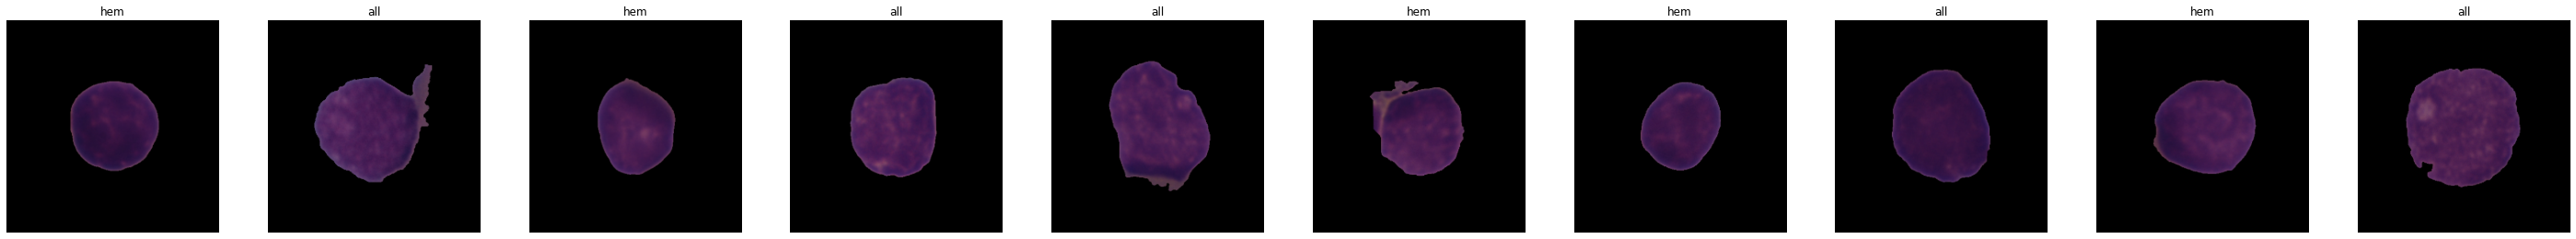

In [ ]:
display_images_and_labels(test_gen)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

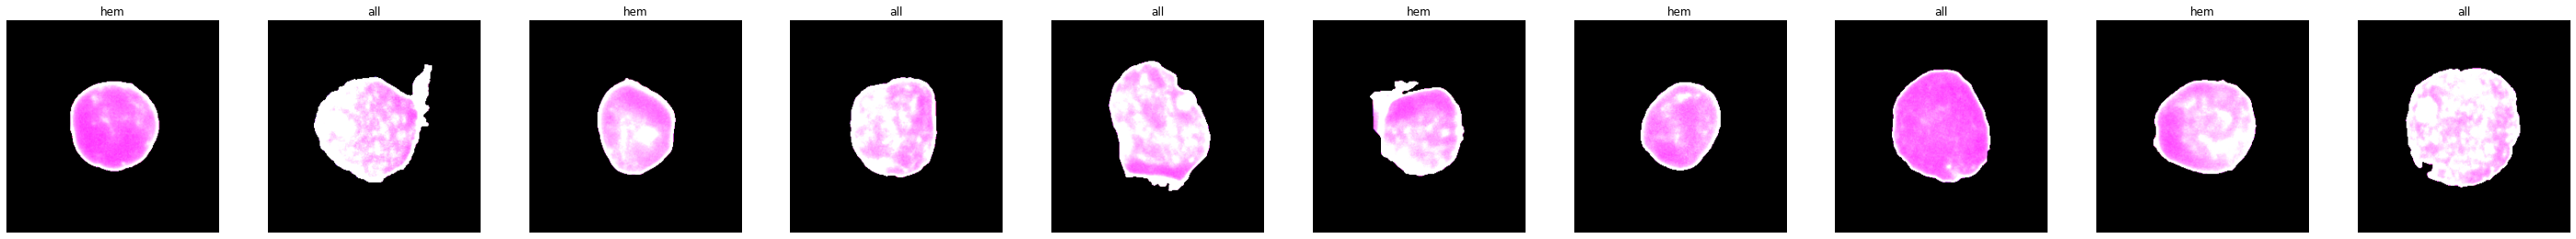

In [ ]:
display_images_and_labels(test_gen, preprocess=True) # preprocessed images

# Load models
Models created and trained in: https://colab.research.google.com/drive/1X5ErmuW_mAAhjuL3pbUfy4UPgIefb4RA?usp=sharing

In [ ]:
inception = tfk.models.load_model(drive_dir+"test_omar_opp/"+"Inception") # load Inception model
# resnet = tfk.models.load_model(all_dir+"ResNet") # load ResNet model
# vgg = tfk.models.load_model(all_dir+"VGG") # load VGG model
model = tfk.models.load_model(drive_dir+"test_omar_opp/"+"Model") # load Model
#with open('/content/drive/MyDrive/GP DataSet/DataSets/C-NMC_Leukemia/training_data/model95-8.pkl', 'rb') as f:
 #   ff = pickle.load(f)



In [ ]:
#model=ff.model

In [ ]:
#models = {"inception": inception, "resnet": resnet, "vgg": vgg, "model": model}
models = {"inception": inception, "model": model}

In [ ]:
inception_history = load_json_file(drive_dir+"test_omar_opp/"+"inception_history.json")
# resnet_history = load_json_file(all_dir+"resnet_history.json")
# vgg_history = load_json_file(all_dir+"vgg_history.json")
model_history = load_json_file(drive_dir+"test_omar_opp/"+"model_history.json")

In [ ]:
#histories = {"inception": inception_history, "resnet": resnet_history, "vgg": vgg_history, "model": model_history}
histories = {"inception": inception_history,  "model": model_history}

# Evaluate models on cross validation set

In [ ]:
inception_val_preds = inception.predict(val_gen)
# resnet_val_preds = resnet.predict(val_gen)
# vgg_val_preds = vgg.predict(val_gen)
model_val_preds = model.predict(val_gen)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
inception_val_preds = inception_val_preds.squeeze()
# resnet_val_preds = resnet_val_preds.squeeze()
# vgg_val_preds = vgg_val_preds.squeeze()
model_val_preds = model_val_preds.squeeze()

In [ ]:
#preds = {"inception": inception_val_preds, "resnet": resnet_val_preds, "vgg": vgg_val_preds, "model": model_val_preds}
preds = {"inception": inception_val_preds,"model": model_val_preds}

In [ ]:
y_val_true = np.array(val_y)

In [ ]:
th = 0.5 # threshold, if y > th then y = 1, else y = 0

In [ ]:
classes = {0: "ALL Cell", 1: "Healthy Cell"}
n_labels = 2

In [ ]:
eval_metrics = "TP	TN	FP	FN	Accuracy	Prevalence	Sensitivity	Specificity	PPV	NPV	AUC	F1	Threshold".split()
print(eval_metrics)

['TP', 'TN', 'FP', 'FN', 'Accuracy', 'Prevalence', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'AUC', 'F1', 'Threshold']


In [ ]:
# Functions to get true positives, true negatives, false positives, and false negatives
def true_positives(y, pred, th=th):
  thresholded_preds = pred > th    
  TP = np.sum((y == 1) & (thresholded_preds == 1))
  return TP

def true_negatives(y, pred, th=th):
  thresholded_preds = pred > th
  TN = np.sum((y == 0) & (thresholded_preds == 0))
  return TN

def false_positives(y, pred, th=th):
  thresholded_preds = pred > th
  FP = np.sum((y == 0) & (thresholded_preds == 1))
  return FP

def false_negatives(y, pred, th=th):
  thresholded_preds = pred > th
  FN = np.sum((y == 1) & (thresholded_preds == 0))
  return FN

In [ ]:
# Function to plot a confusion matrix for a model based on its predictions
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix", xlabel="Prediction", ylabel="True", th=th):
  conf_matrix = confusion_matrix(y_true, (y_pred > th))
  names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
  percents = ["{0:.3%}".format(num) for num in conf_matrix.flatten()/np.sum(conf_matrix)]
  labels = []
  for i in range(conf_matrix.shape[0]):
    labels.append([])
    for j in range(conf_matrix.shape[1]):
      labels[-1].append(f"{names[2*i+j]}\n{conf_matrix[i, j]}\n{percents[2*i+j]}")
  sns.heatmap(conf_matrix, annot=labels, cmap='Blues', fmt='')
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)

In [ ]:
# Function to get the accuracy
def get_accuracy(y, pred, th=th, epsilon=1e-100):
  TP = true_positives(y, pred, th)
  FP = false_positives(y, pred, th)
  TN = true_negatives(y, pred, th)
  FN = false_negatives(y, pred, th)
  accuracy = (TP + TN) / (TP + TN + FP + FN + epsilon)
  return accuracy

In [ ]:
# Function to get the prevalence
def get_prevalence(y, class_num=1):
  prevalence = np.mean(y==class_num)
  return prevalence

In [ ]:
# Function to get the sensitivity
def get_sensitivity(y, pred, th=th, epsilon=1e-100):
  TP = true_positives(y, pred, th)
  FN = false_negatives(y, pred, th)
  sensitivity = TP / (TP + FN + epsilon)
  return sensitivity

In [ ]:
# Function to get the specificity
def get_specificity(y, pred, th=th, epsilon=1e-100):
    TN = true_negatives(y, pred, th)
    FP = false_positives(y, pred, th) 
    specificity = TN / (TN + FP + epsilon)
    return specificity

In [ ]:
# Function to get the ppv
def get_ppv(y, pred, th=th, epsilon=1e-100):
  TP = true_positives(y, pred, th)
  FP = false_positives(y, pred, th)
  PPV = TP / (TP + FP + epsilon)
  return PPV

In [ ]:
# Function to get the npv
def get_npv(y, pred, th=th, epsilon=1e-100):
    TN = true_negatives(y, pred, th)
    FN = false_negatives(y, pred, th)
    NPV = TN / (TN + FN + epsilon)
    return NPV

In [ ]:
def get_f1_score(y, pred, th=th, epsilon=1e-100):
  TP = true_positives(y, pred, th)
  FP = false_positives(y, pred, th)
  FN = false_negatives(y, pred, th)
  f1_score = TP/(TP + 0.5 * (FP + FN) + epsilon)
  return f1_score

In [ ]:
# Function to plot the roc curve
def plotROCCurve(y, model_name, n_labels=n_labels):
  pred = preds[model_name]
  fpr, tpr, _ = roc_curve(y, pred)
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr,
          lw=2, label=f'ROC curve for class {classes[1]} (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver operating characteristic curve for {model_name}')
  plt.legend(loc="lower right")
  plt.show()

In [ ]:
# Function to plot history
def plotHistory(history_key, ylabel, xlabel="Epochs"):
  lines = []
  for key in models.keys():
    line, = plt.plot(histories[key][history_key], label=key)
    lines.append(line)
  plt.legend(handles=lines)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)

In [ ]:
# Function to plot the history of the model on the training set and the validation set
def plotTrainAndValHistory(history_key, model_name, title, xlabel="Epochs"):
  checkpoint_epoch = np.argmax(histories[model_name]['val_accuracy'])
  line1, = plt.plot(histories[model_name][history_key], color='blue', label='training ' + history_key)
  line2, = plt.plot(histories[model_name]['val_'+history_key], color='orange', label='validation ' + history_key)
  line3 = plt.axvline(x=checkpoint_epoch, linestyle='dashed', color='red', label='Checkpoint epoch')
  plt.legend(handles=[line1, line2, line3])
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(history_key)

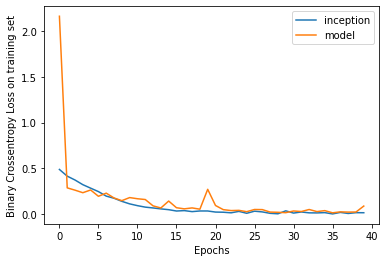

In [ ]:
# Plot history of binary crossentropy loss on training set (lower loss = better)
plotHistory("loss", "Binary Crossentropy Loss on training set")

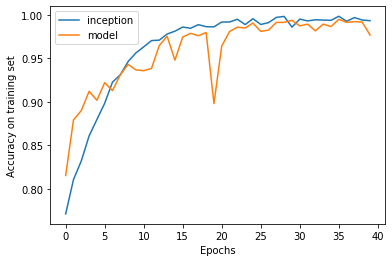

In [ ]:
# Plot history of accuracy on training set (higher accuracy = better)
plotHistory("accuracy", "Accuracy on training set")

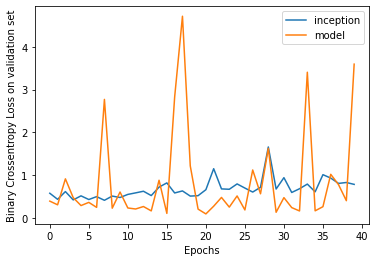

In [ ]:
# Plot history of binary crossentropy loss on validation set (lower loss = better)
plotHistory("val_loss", "Binary Crossentropy Loss on validation set")

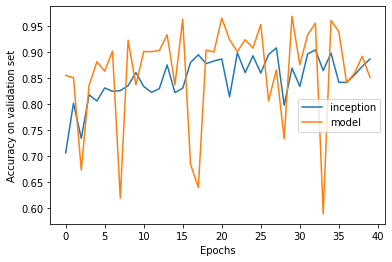

In [ ]:
# Plot history of accuracy on training set (higher accuracy = better)
plotHistory("val_accuracy", "Accuracy on validation set")

In [ ]:
# plotTrainAndValHistory("loss", "inception", "Binary Crossentropy Loss for Inception Model")

In [ ]:
# plotTrainAndValHistory("loss", "resnet", "Binary Crossentropy Loss for ResNet Model")

In [ ]:
# plotTrainAndValHistory("loss", "vgg", "Binary Crossentropy Loss for VGG Model")

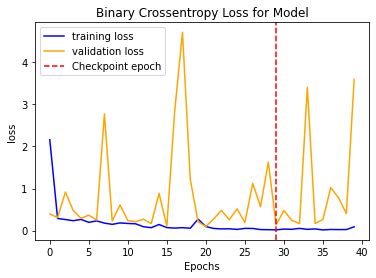

In [ ]:
plotTrainAndValHistory("loss", "model", "Binary Crossentropy Loss for Model")

In [ ]:
# plotTrainAndValHistory("accuracy", "inception", "Accuracy for Inception Model")

In [ ]:
# plotTrainAndValHistory("accuracy", "resnet", "Accuracy for ResNet Model")

In [ ]:
# plotTrainAndValHistory("accuracy", "vgg", "Accuracy for VGG Model")

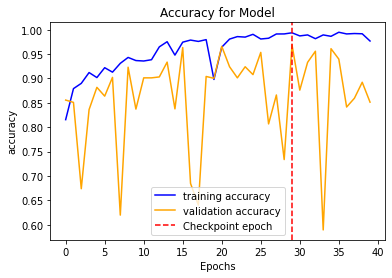

In [ ]:
plotTrainAndValHistory("accuracy", "model", "Accuracy for Model")

In [ ]:
plot_confusion_matrix(y_val_true, inception_val_preds, "Inception Model Confusion Matrix")

In [ ]:
# plot_confusion_matrix(y_val_true, resnet_val_preds, "ResNet Model Confusion Matrix")

In [ ]:
# plot_confusion_matrix(y_val_true, vgg_val_preds, "VGG Model Confusion Matrix")

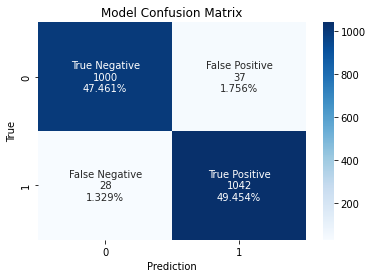

In [ ]:
plot_confusion_matrix(y_val_true, model_val_preds, "Model Confusion Matrix")

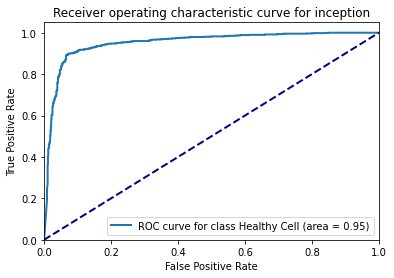

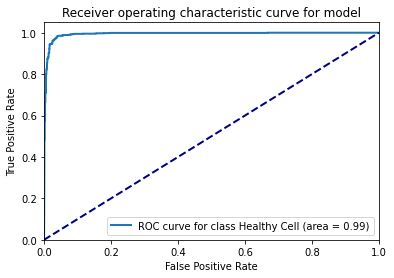

In [ ]:
# Plot ROC curves for each model
for model_name in preds.keys():
  plotROCCurve(y_val_true, model_name)

In [ ]:
evaluations_val = {metric: {model_name:None for model_name in models.keys()} for metric in eval_metrics}

In [ ]:
for model_name, pred in preds.items():
  TP = true_positives(y_val_true, pred)
  TN = true_negatives(y_val_true, pred)
  FP = false_positives(y_val_true, pred)
  FN = false_negatives(y_val_true, pred)
  accuracy = get_accuracy(y_val_true, pred)
  prevalence = get_prevalence(y_val_true)
  sensitivity = get_sensitivity(y_val_true, pred)
  specificity = get_specificity(y_val_true, pred)
  ppv = get_ppv(y_val_true, pred)
  npv = get_npv(y_val_true, pred)
  auc_value = roc_auc_score(y_val_true, pred)
  f1_score = get_f1_score(y_val_true, pred)

  evaluations_val["TP"][model_name] = TP
  evaluations_val["TN"][model_name] = TN
  evaluations_val["FP"][model_name] = FP
  evaluations_val["FN"][model_name] = FN
  evaluations_val["Accuracy"][model_name] = accuracy
  evaluations_val["Prevalence"][model_name] = prevalence
  evaluations_val["Sensitivity"][model_name] = sensitivity
  evaluations_val["Specificity"][model_name] = specificity
  evaluations_val["PPV"][model_name] = ppv
  evaluations_val["NPV"][model_name] = npv
  evaluations_val["AUC"][model_name] = auc_value
  evaluations_val["F1"][model_name] = f1_score
  evaluations_val["Threshold"][model_name] = th

In [ ]:
evaluations_val = pd.DataFrame(evaluations_val)

In [ ]:
display(evaluations_val)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
inception,945,969,68,125,0.908401,0.507831,0.883178,0.934426,0.932873,0.885740,0.951114,0.907345,0.5
model,1042,1000,37,28,0.969150,0.507831,0.973832,0.964320,0.965709,0.972763,0.993608,0.969753,0.5


# Evaluate model on test set

In [ ]:
model_test_preds = model.predict(test_gen)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
model_test_preds = model_test_preds.squeeze()

In [ ]:
y_test_true = np.array(test_y)

In [ ]:
th = 0.5 # threshold, if y > th then y = 1, else y = 0

In [ ]:
classes = {0: "ALL Cell", 1: "Healthy Cell"}
n_labels = 2

In [ ]:
eval_metrics = "TP	TN	FP	FN	Accuracy	Prevalence	Sensitivity	Specificity	PPV	NPV	AUC	F1	Threshold".split()
print(eval_metrics)

['TP', 'TN', 'FP', 'FN', 'Accuracy', 'Prevalence', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'AUC', 'F1', 'Threshold']


In [ ]:
# Functions to get true positives, true negatives, false positives, and false negatives
def true_positives(y, pred, th=th):
  thresholded_preds = pred > th    
  TP = np.sum((y == 1) & (thresholded_preds == 1))
  return TP

def true_negatives(y, pred, th=th):
  thresholded_preds = pred > th
  TN = np.sum((y == 0) & (thresholded_preds == 0))
  return TN

def false_positives(y, pred, th=th):
  thresholded_preds = pred > th
  FP = np.sum((y == 0) & (thresholded_preds == 1))
  return FP

def false_negatives(y, pred, th=th):
  thresholded_preds = pred > th
  FN = np.sum((y == 1) & (thresholded_preds == 0))
  return FN

In [ ]:
# Function to plot a confusion matrix for a model based on its predictions
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix", xlabel="Prediction", ylabel="True", th=th):
  conf_matrix = confusion_matrix(y_true, (y_pred > th))
  names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
  percents = ["{0:.3%}".format(num) for num in conf_matrix.flatten()/np.sum(conf_matrix)]
  labels = []
  for i in range(conf_matrix.shape[0]):
    labels.append([])
    for j in range(conf_matrix.shape[1]):
      labels[-1].append(f"{names[2*i+j]}\n{conf_matrix[i, j]}\n{percents[2*i+j]}")
  sns.heatmap(conf_matrix, annot=labels, cmap='Blues', fmt='')
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)

In [ ]:
# Function to get the accuracy
def get_accuracy(y, pred, th=th, epsilon=1e-100):
  TP = true_positives(y, pred, th)
  FP = false_positives(y, pred, th)
  TN = true_negatives(y, pred, th)
  FN = false_negatives(y, pred, th)
  accuracy = (TP + TN) / (TP + TN + FP + FN + epsilon)
  return accuracy

In [ ]:
# Function to get the prevalence
def get_prevalence(y, class_num=1):
  prevalence = np.mean(y==class_num)
  return prevalence

In [ ]:
# Function to get the sensitivity
def get_sensitivity(y, pred, th=th, epsilon=1e-100):
  TP = true_positives(y, pred, th)
  FN = false_negatives(y, pred, th)
  sensitivity = TP / (TP + FN + epsilon)
  return sensitivity

In [ ]:
# Function to get the specificity
def get_specificity(y, pred, th=th, epsilon=1e-100):
    TN = true_negatives(y, pred, th)
    FP = false_positives(y, pred, th) 
    specificity = TN / (TN + FP + epsilon)
    return specificity

In [ ]:
# Function to get the ppv
def get_ppv(y, pred, th=th, epsilon=1e-100):
  TP = true_positives(y, pred, th)
  FP = false_positives(y, pred, th)
  PPV = TP / (TP + FP + epsilon)
  return PPV

In [ ]:
# Function to get the npv
def get_npv(y, pred, th=th, epsilon=1e-100):
    TN = true_negatives(y, pred, th)
    FN = false_negatives(y, pred, th)
    NPV = TN / (TN + FN + epsilon)
    return NPV

In [ ]:
def get_f1_score(y, pred, th=th, epsilon=1e-100):
  TP = true_positives(y, pred, th)
  FP = false_positives(y, pred, th)
  FN = false_negatives(y, pred, th)
  f1_score = TP/(TP + 0.5 * (FP + FN) + epsilon)
  return f1_score

In [ ]:
# Function to plot the roc curve (for test set)
def plotROCCurveTestSet(y, model_name, pred, n_labels=n_labels):
  fpr, tpr, _ = roc_curve(y, pred)
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr,
          lw=2, label=f'ROC curve for class {classes[1]} (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver operating characteristic curve for {model_name}')
  plt.legend(loc="lower right")
  plt.show()

In [ ]:
# Function to plot history
def plotHistory(history_key, ylabel, xlabel="Epochs"):
  lines = []
  for key in models.keys():
    line, = plt.plot(histories[key][history_key], label=key)
    lines.append(line)
  plt.legend(handles=lines)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)

In [ ]:
# Function to plot the history of the model on the training set and the validation set
def plotTrainAndValHistory(history_key, model_name, title, xlabel="Epochs"):
  checkpoint_epoch = np.argmax(histories[model_name]['val_accuracy'])
  line1, = plt.plot(histories[model_name][history_key], color='blue', label='training ' + history_key)
  line2, = plt.plot(histories[model_name]['val_'+history_key], color='orange', label='validation ' + history_key)
  line3 = plt.axvline(x=checkpoint_epoch, linestyle='dashed', color='red', label='Checkpoint epoch')
  plt.legend(handles=[line1, line2, line3])
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(history_key)

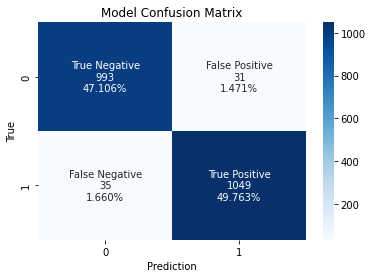

In [ ]:
plot_confusion_matrix(y_test_true, model_test_preds, "Model Confusion Matrix")

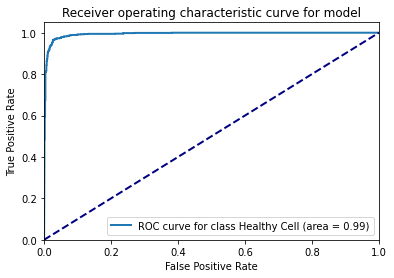

In [ ]:
plotROCCurveTestSet(y_test_true, "model", model_test_preds)

In [ ]:
evaluations_test = {metric: {"model":None} for metric in eval_metrics}

In [ ]:
TP = true_positives(y_test_true, model_test_preds)
TN = true_negatives(y_test_true, model_test_preds)
FP = false_positives(y_test_true, model_test_preds)
FN = false_negatives(y_test_true, model_test_preds)
accuracy = get_accuracy(y_test_true, model_test_preds)
prevalence = get_prevalence(y_test_true)
sensitivity = get_sensitivity(y_test_true, model_test_preds)
specificity = get_specificity(y_test_true, model_test_preds)
ppv = get_ppv(y_test_true, model_test_preds)
npv = get_npv(y_test_true, model_test_preds)
auc_value = roc_auc_score(y_test_true, model_test_preds)
f1_score = get_f1_score(y_test_true, model_test_preds)

evaluations_test["TP"]["model"] = TP
evaluations_test["TN"]["model"] = TN
evaluations_test["FP"]["model"] = FP
evaluations_test["FN"]["model"] = FN
evaluations_test["Accuracy"]["model"] = accuracy
evaluations_test["Prevalence"]["model"] = prevalence
evaluations_test["Sensitivity"]["model"] = sensitivity
evaluations_test["Specificity"]["model"] = specificity
evaluations_test["PPV"]["model"] = ppv
evaluations_test["NPV"]["model"] = npv
evaluations_test["AUC"]["model"] = auc_value
evaluations_test["F1"]["model"] = f1_score
evaluations_test["Threshold"]["model"] = th

In [ ]:
evaluations_test = pd.DataFrame(evaluations_test)

In [ ]:
display(evaluations_test)

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
model,1049,993,31,35,0.968691,0.514231,0.967712,0.969727,0.971296,0.965953,0.993406,0.969501,0.5
